This script plots slab boundary layer model (SBLM) quasi-steady-state solutions of BL/surface wind convergence. Comparisons are made with ERA5 data in a different script (uvrvw_curves_final.ipynb).

Author: Alex Gonzalez (alex.gonzalez@whoi.edu). Oct 2023.

In [3]:
import numpy as np 

import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import netCDF4

from mpl_toolkits.axes_grid1 import ImageGrid

computer_name = 'alexgonzalez'

In [5]:
mainfolder = '/Users/'+computer_name+'/Google Drive/My Drive/ITCZ_sblm_1D/ERA5/'

# output directory

figfolder = mainfolder+'figures/'

# input directories
dri = mainfolder+'progs/control/'

nlat = 241
nmon = 12
nt = 721

fni = 'sst_allmon.nc'   # file name
data_sst = xr.open_dataset(dri+fni, decode_times=False)
w_sst = data_sst['w'][nt-1,:,:]
v_sst = data_sst['v'][nt-1,:,:]

# input directories
dri = mainfolder+'progs/control/'

fni = 'Tv_allmon.nc'   # file name
data_tv = xr.open_dataset(dri+fni, decode_times=False)
w_tv = data_tv['w'][nt-1,:,:]
v_tv = data_tv['v'][nt-1,:,:]

fni = 'tv_FT_allmon.nc'   # file name
data_FT = xr.open_dataset(dri+fni, decode_times=False)
w_FT = data_FT['w'][nt-1,:,:]
v_FT = data_FT['v'][nt-1,:,:]

fni = 'gp850_allmon.nc'   # file name
data_gp = xr.open_dataset(dri+fni, decode_times=False)
w_gp = data_gp['w'][nt-1,:,:]
v_gp = data_gp['v'][nt-1,:,:]

In [6]:
w_sst

<xarray.DataArray 'w' (month: 12, phi_out: 241)>
array([[ 1.979955e-03,  1.884993e-03,  1.611109e-03, ..., -9.337416e-04,
        -7.565215e-04, -6.952264e-04],
       [ 2.023969e-03,  1.928124e-03,  1.651171e-03, ..., -5.657896e-04,
        -4.364166e-04, -3.948730e-04],
       [ 1.883018e-03,  1.816864e-03,  1.619902e-03, ...,  1.485917e-04,
         2.492084e-04,  2.787108e-04],
       ...,
       [ 1.948872e-03,  1.906902e-03,  1.775555e-03, ...,  1.659391e-04,
         3.391274e-04,  3.999071e-04],
       [ 2.004186e-03,  1.936699e-03,  1.737247e-03, ..., -2.978370e-04,
        -9.927401e-05, -2.973951e-05],
       [ 1.963916e-03,  1.880367e-03,  1.638105e-03, ..., -8.636919e-04,
        -6.911485e-04, -6.305225e-04]])
Coordinates:
    t_out    float64 0.0
  * phi_out  (phi_out) float64 -0.5236 -0.5192 -0.5149 ... 0.5149 0.5192 0.5236
  * month    (month) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Attributes:
    long_name:  vertical wind at top of boundary layer
    units:      m/s

In [7]:
month = np.arange(1,13,1)

In [8]:
print(w_sst.max()*1000)
print(w_tv.max()*1000)
print(w_FT.max()*1000)
print(w_gp.max()*1000)

<xarray.DataArray 'w' ()>
array(11.58606197)
Coordinates:
    t_out    float64 0.0
<xarray.DataArray 'w' ()>
array(10.66825154)
Coordinates:
    t_out    float64 0.0
<xarray.DataArray 'w' ()>
array(9.07874461)
Coordinates:
    t_out    float64 0.0
<xarray.DataArray 'w' ()>
array(4.46123163)
Coordinates:
    t_out    float64 0.0


In [9]:
v_tv.shape

(12, 241)

In [10]:
phi = data_tv['phi_out'].values

dphi = np.abs(phi[1]-phi[0])
lat_sblm = phi*180/np.pi

In [11]:
dri = mainfolder+'/progs/data_preproc/monthly/'

In [12]:
fni = 'h_forcing2.nc'   # file name
datah = xr.open_dataset(dri+fni, decode_times=False)
h = datah['h'].values

In [13]:
c_tv = w_tv/h*0
c_sst = w_sst/h*0

c_tv_FT = w_FT/h*0
c_gp = w_gp/h*0

In [14]:
def center_fd(field,x):
    nx = field.shape[0]
    dfdx = np.zeros(nx)
    dfdx[1:nx-1] = (field[2:nx] - field[0:nx-2])/(x[2:nx] - x[0:nx-2])
    dfdx[0]      = (field[1] - field[0])/(x[1] - x[0])
    dfdx[nx-1]     = (field[nx-1] - field[nx-2])/(x[nx-1] - x[nx-2])
    return dfdx

ae = 6.371e6

In [15]:
# compute derived fields as a function of latitude
for mm in range(0,nmon,1):
    c_tv[mm,:] = -center_fd(v_tv[mm,:].values,phi)/ae + v_tv[mm,:]*np.tan(phi)/ae
    c_sst[mm,:] = -center_fd(v_sst[mm,:].values,phi)/ae + v_sst[mm,:]*np.tan(phi)/ae
    c_tv_FT[mm,:] = -center_fd(v_FT[mm,:].values,phi)/ae + v_FT[mm,:]*np.tan(phi)/ae
    c_gp[mm,:] = -center_fd(v_gp[mm,:].values,phi)/ae + v_gp[mm,:]*np.tan(phi)/ae

In [16]:
# create density contour array based on min and max values
lev_p = np.arange(-2.1, 2.4, .3)
lev_p_upper = np.arange(-1.5, 1.65, .15)
color_map_rb = plt.cm.get_cmap('RdBu')#.reversed()
#'Full T$_{v}$','SST','T$_{v,850-900}$',r'PGF$_{850}$'

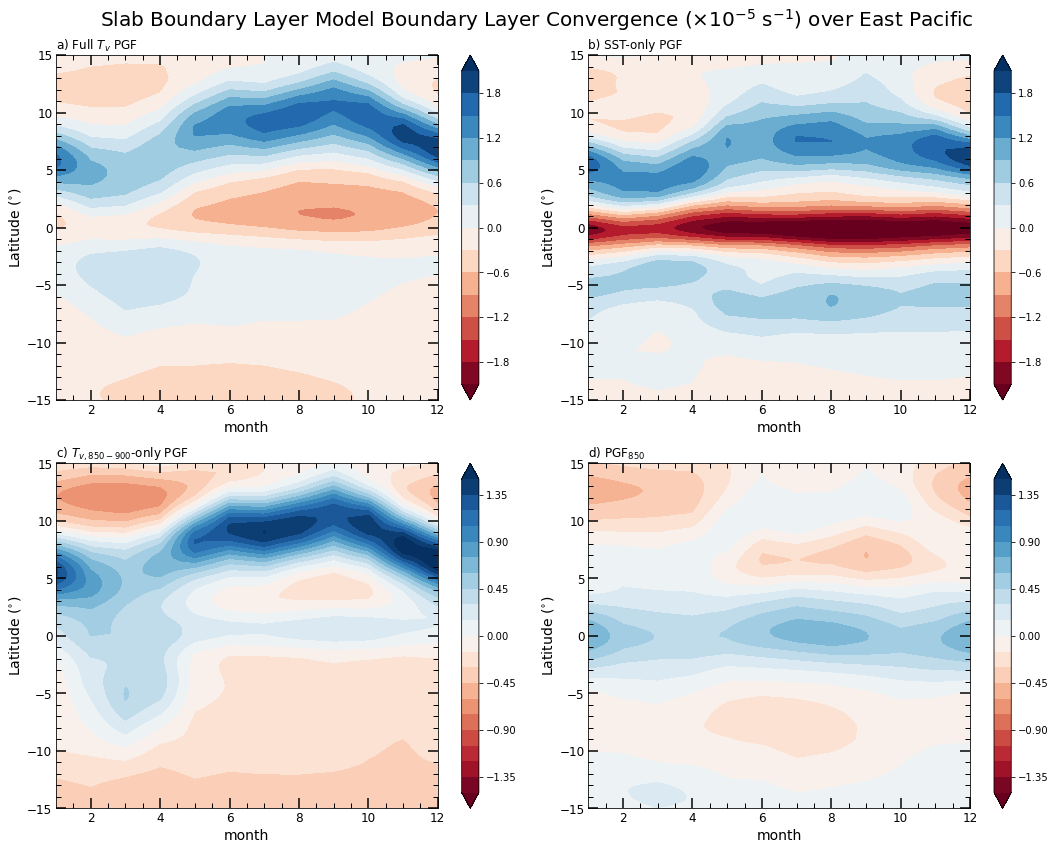

In [17]:
npan = 4
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(15, 12), tight_layout='true')
fig.suptitle(r'Slab Boundary Layer Model Surface Wind Convergence ($\times 10^{-5}$ s$^{-1}$) over East Pacific', fontsize=20)
for j in range(0,npan,1):
   ax1 = fig.add_subplot(2,2,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', labelsize=12)
   ax1.tick_params(axis='y', labelsize=12)
   #plt.gca().invert_yaxis() 
   plt.xlabel('month', fontsize=14)
   plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.ylim(-15,15)
   if j == 0:
       plt.title(r'a) Full $T_{v}$ PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_tv.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 1:
       plt.title(r'b) SST-only PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_sst.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 2:
       plt.title(r'c) $T_{v,850-900}$-only PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_tv_FT.transpose()*10**5, cmap = color_map_rb, levels=lev_p_upper, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 3:
       plt.title(r'd) PGF$_{850}$',loc='left')
       cf = plt.contourf(month, lat_sblm, c_gp.transpose()*10**5, cmap = color_map_rb, levels=lev_p_upper, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 4:
       plt.title('SST PGF anom',loc='left')
       cf = plt.contourf(month, lat_sblm, (c_sst - c_tv)*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
        
# This plot tells us the magnitude of the divergence and convergence is way too strong in SST only simulations
# However, it doesn't say whether or not the latitudinal pattern is off

NameError: name 'c_sst2' is not defined

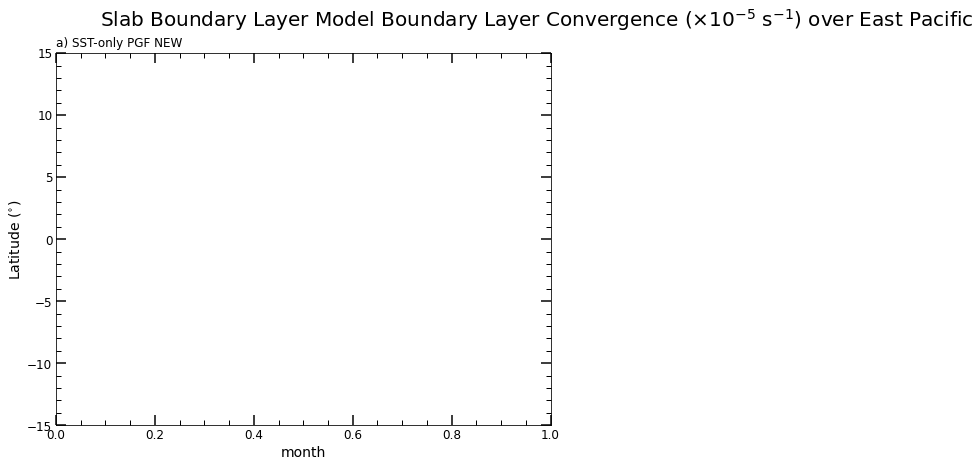

In [18]:
npan = 4
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(15, 12), tight_layout='true')
fig.suptitle(r'Slab Boundary Layer Model Surface Wind Convergence ($\times 10^{-5}$ s$^{-1}$) over East Pacific', fontsize=20)
for j in range(0,npan,1):
   ax1 = fig.add_subplot(2,2,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', labelsize=12)
   ax1.tick_params(axis='y', labelsize=12)
   #plt.gca().invert_yaxis() 
   plt.xlabel('month', fontsize=14)
   plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.ylim(-15,15)
   if j == 0:
       plt.title(r'a) SST-only PGF NEW',loc='left')
       cf = plt.contourf(month, lat_sblm, c_sst2.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 1:
       plt.title(r'b) SST-only PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_sst*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 3:
       plt.title(r'd) Full $T_{v}$ PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_tv*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 2:
       plt.title(r'c) Full $T_{v}$ PGF NEW',loc='left')
       cf = plt.contourf(month, lat_sblm, c_tv2.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 4:
       plt.title('SST PGF anom',loc='left')
       cf = plt.contourf(month, lat_sblm, (c_sst - c_tv)*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
        
# This plot tells us the magnitude of the divergence and convergence is way too strong in SST only simulations
# However, it doesn't say whether or not the latitudinal pattern is off

In [ ]:
# create density contour array based on min and max values
lev_p_norm = np.arange(-1., 1.1, .1)

In [19]:
c_tv_xr = xr.DataArray(c_tv,coords=[month,lat_sblm],dims=('month','latitude'))
c_sst_xr = xr.DataArray(c_sst,coords=[month,lat_sblm],dims=('month','latitude'))
c_tv_FT_xr = xr.DataArray(c_tv_FT,coords=[month,lat_sblm],dims=('month','latitude'))

# do it for new output

In [20]:
cv_tv_NH = c_tv_xr.sel(latitude=slice(2.5,12.5)).max(dim='latitude')
cv_sst_NH = c_sst_xr.sel(latitude=slice(2.5,12.5)).max(dim='latitude')
cv_tv_FT_NH = c_tv_FT_xr.sel(latitude=slice(2.5,12.5)).max(dim='latitude')

# do it for new output

In [21]:
cv_tv_SH = c_tv_xr.sel(latitude=slice(-12.5,-2.5)).max(dim='latitude')
cv_sst_SH = c_sst_xr.sel(latitude=slice(-12.5,-2.5)).max(dim='latitude')
cv_tv_FT_SH = c_tv_FT_xr.sel(latitude=slice(-12.5,0.)).max(dim='latitude')

In [22]:
cv_tv_EQ = c_tv_xr.sel(latitude=slice(-2.5,2.5)).min(dim='latitude')
cv_sst_EQ = c_sst_xr.sel(latitude=slice(-2.5,2.5)).min(dim='latitude')
cv_tv_FT_EQ = c_tv_FT_xr.sel(latitude=slice(-2.5,2.5)).min(dim='latitude')

In [23]:
lat_NH_tv = np.zeros((nmon))
lat_SH_tv = np.zeros((nmon))
lat_EQ_tv = np.zeros((nmon))

lat_NH_sst = np.zeros((nmon))
lat_SH_sst = np.zeros((nmon))
lat_EQ_sst = np.zeros((nmon))

lat_NH_tv_FT = np.zeros((nmon))
lat_SH_tv_FT = np.zeros((nmon))
lat_EQ_tv_FT = np.zeros((nmon))
for mm in range(0,nmon,1):
    lat_NH_tv[mm] = c_tv_xr['latitude'].where(c_tv_xr[mm,:]==cv_tv_NH[mm],drop=True).values
    lat_SH_tv[mm] = c_tv_xr['latitude'].where(c_tv_xr[mm,:]==cv_tv_SH[mm],drop=True).values
    lat_EQ_tv[mm] = c_tv_xr['latitude'].where(c_tv_xr[mm,:]==cv_tv_EQ[mm],drop=True).values
    
    lat_NH_tv_FT[mm] = c_tv_FT_xr['latitude'].where(c_tv_FT_xr[mm,:]==cv_tv_FT_NH[mm],drop=True).values
    lat_SH_tv_FT[mm] = c_tv_FT_xr['latitude'].where(c_tv_FT_xr[mm,:]==cv_tv_FT_SH[mm],drop=True).values
    lat_EQ_tv_FT[mm] = c_tv_FT_xr['latitude'].where(c_tv_FT_xr[mm,:]==cv_tv_FT_EQ[mm],drop=True).values
    
    lat_NH_sst[mm] = c_sst_xr['latitude'].where(c_sst_xr[mm,:]==cv_sst_NH[mm],drop=True).values
    lat_SH_sst[mm] = c_sst_xr['latitude'].where(c_sst_xr[mm,:]==cv_sst_SH[mm],drop=True).values
    lat_EQ_sst[mm] = c_sst_xr['latitude'].where(c_sst_xr[mm,:]==cv_sst_EQ[mm],drop=True).values

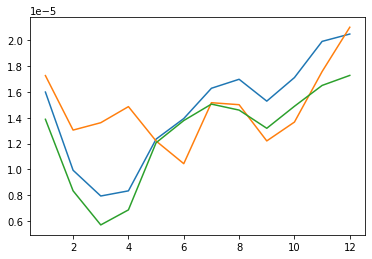

In [24]:
plt.plot(month,cv_tv_NH)
plt.plot(month,cv_sst_NH)
plt.plot(month,cv_tv_FT_NH)

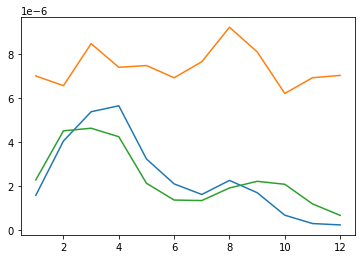

In [25]:
plt.plot(month,cv_tv_SH)
plt.plot(month,cv_sst_SH)
plt.plot(month,cv_tv_FT_SH)

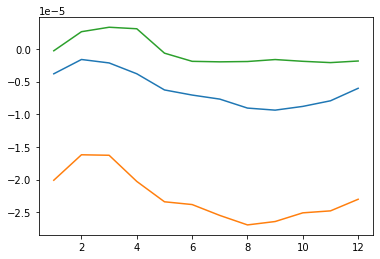

In [26]:
plt.plot(month,cv_tv_EQ)
plt.plot(month,cv_sst_EQ)
plt.plot(month,cv_tv_FT_EQ)

In [27]:
ratio_tv_FT_SH_EQ = (cv_tv_FT_SH/cv_tv_FT_EQ)
ratio_tv_FT_SH_EQ_np = -np.where(np.abs(ratio_tv_FT_SH_EQ.values)>1.5,np.nan,ratio_tv_FT_SH_EQ.values)
ratio_tv_FT_SH_EQ_np

array([        nan,         nan, -1.39350248, -1.37304161,         nan,
        0.70999992,  0.67043875,  0.98550896,  1.35253439,  1.08989861,
        0.56084107,  0.35253151])

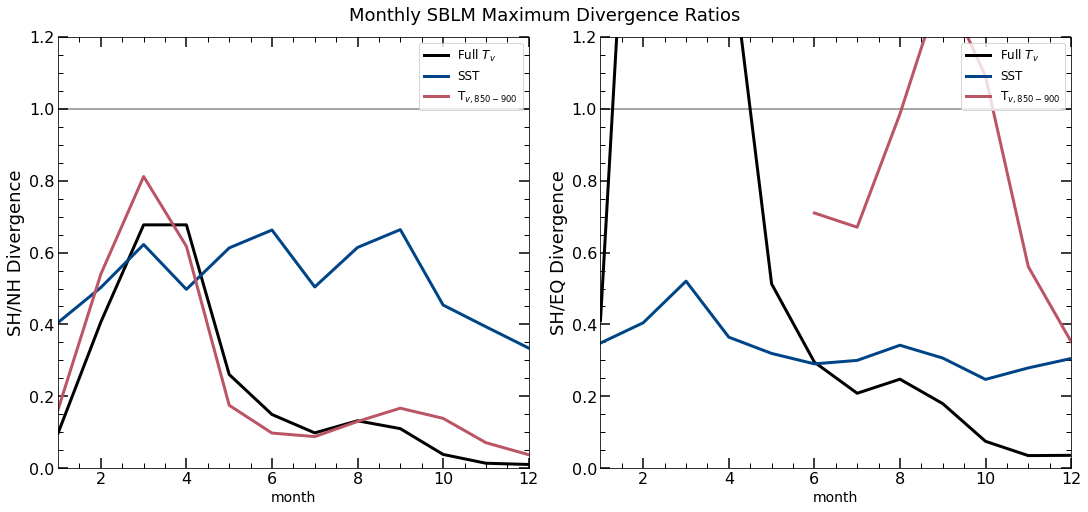

In [28]:

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

npan = 2
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(15, 7), constrained_layout=True)
fig.suptitle('Monthly SBLM Maximum Divergence Ratios', fontsize=18)#, y=0.78)
for jj in range(0,npan,1):
   ax1 = fig.add_subplot(1,npan,jj+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
  
   ax1.tick_params(axis='x', labelsize=16)
   ax1.tick_params(axis='y', labelsize=16)
   plt.xlim(1,12)
   plt.xlabel(r'month', fontsize=14)
   plt.ylim(0.,1.2)
   if jj == 0: 
      color = 'k'
      lns1 = ax1.plot(month,cv_tv_SH/cv_tv_NH, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,cv_sst_SH/cv_sst_NH, color=color, linewidth='3')
      color = '#BB5566'
      lns3 = ax1.plot(month,cv_tv_FT_SH/cv_tv_FT_NH, color=color, linewidth='3')
      ax1.set_ylabel('SH/NH Divergence', fontsize=18)
      plt.legend(['Full $T_v$','SST',r'T$_{v,850-900}$'],loc=1,fontsize=12) 
   if jj == 1: 
      color = 'k'
      lns1 = ax1.plot(month,-cv_tv_SH/cv_tv_EQ, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,-cv_sst_SH/cv_sst_EQ, color=color, linewidth='3')
      color = '#BB5566'
      lns3 = ax1.plot(month,ratio_tv_FT_SH_EQ_np, color=color, linewidth='3')
      ax1.set_ylabel('SH/EQ Divergence', fontsize=18)
      plt.legend(['Full $T_v$','SST',r'T$_{v,850-900}$'],loc=1,fontsize=12)
   
   plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
   plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)

# This plot tells us whether what months the latitudinal pattern is off
# The asymmetry between NH and SH shows us that always the NH convergence is stronger in reality close to double in Mar, Apr
# SST only has large discrepancies in SH/NH asymmetry, mainly during June through Dec (when low clouds are most impactful)

# EQ divergence always stronger than SH convergence in reality (except Mar); largest asymmetry in June and Oct
# SST only has large discrepancies in SH/EQ asymmetry; too much EQ divergence compared to SH convergence in Feb-Apr
# SST only has large discrepancies in SH/EQ asymmetry; too much SH convergence compared to EQ divergence in July–Dec

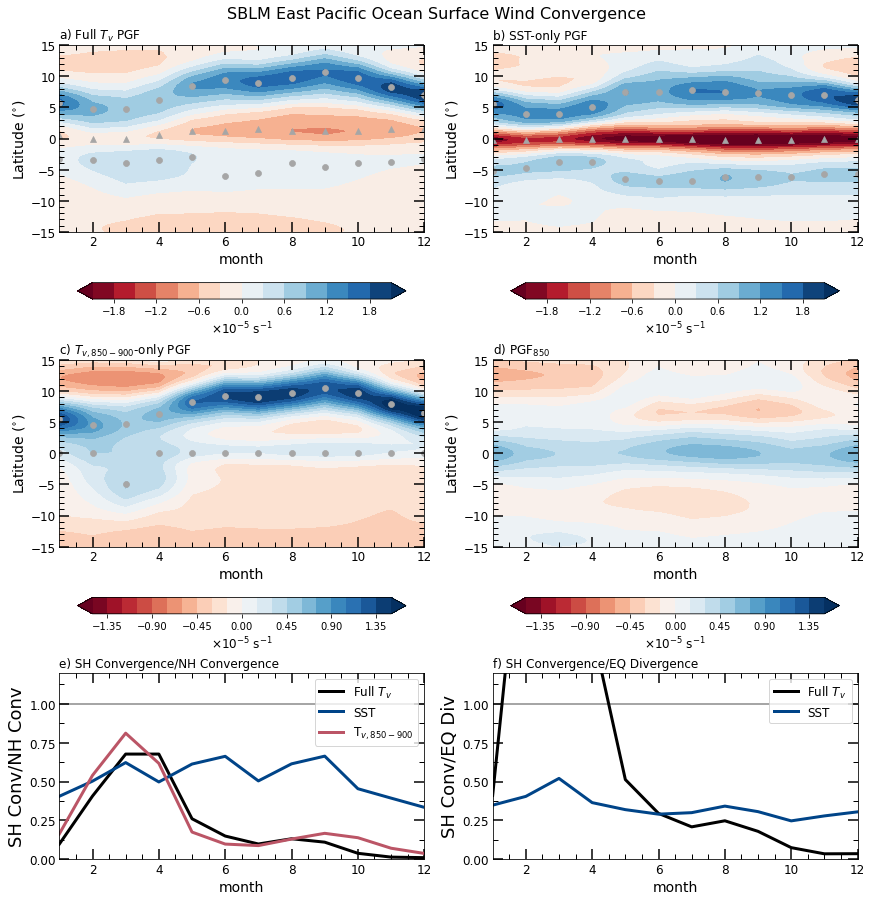

In [30]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

npan = 6
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(12, 15), constrained_layout='true')
fig.suptitle(r'SBLM East Pacific Ocean Surface Wind Convergence', fontsize=16)
for j in range(0,npan,1):
   ax1 = plt.subplot(4,2,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', labelsize=12)
   ax1.tick_params(axis='y', labelsize=12)
   #plt.gca().invert_yaxis() 
   plt.xlabel('month', fontsize=14)
   plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.ylim(-15,15)
   if j == 0:
       plt.title(r'a) Full $T_{v}$ PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_tv.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
       cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
       sc = plt.scatter(month,lat_NH_tv,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_SH_tv,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_EQ_tv,color='0.65', marker='^',linewidth=0.7)
   if j == 1:
       plt.title(r'b) SST-only PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_sst.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
       cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
       sc = plt.scatter(month,lat_NH_sst,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_SH_sst,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_EQ_sst,color='0.65', marker='^',linewidth=0.7)
   if j == 4: 
      plt.title(r'e) SH Convergence/NH Convergence',loc='left')
      color = 'k'
      lns1 = ax1.plot(month,cv_tv_SH/cv_tv_NH, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,cv_sst_SH/cv_sst_NH, color=color, linewidth='3')
      color = '#BB5566'
      lns3 = ax1.plot(month,cv_tv_FT_SH/cv_tv_FT_NH, color=color, linewidth='3')
      plt.ylabel('SH Conv/NH Conv', fontsize=18)
      plt.legend([r'Full $T_{v}$','SST',r'T$_{v,850-900}$'],loc=1,fontsize=12)
      plt.xlabel(r'month', fontsize=14) 
      plt.xlim(1,12)
      plt.ylim(0.,1.2)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
      plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)
      locs, labels = plt.yticks()  # Get the current locations and labels.
      plt.yticks(np.arange(0, 1.1, step=0.25))  # Set label locations.
      ax1.yaxis.set_minor_locator(MultipleLocator(0.125))
   if j == 5: 
      plt.title(r'f) SH Convergence/EQ Divergence',loc='left')
      color = 'k'
      lns1 = ax1.plot(month,-cv_tv_SH/cv_tv_EQ, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,-cv_sst_SH/cv_sst_EQ, color=color, linewidth='3')
      #plt.legend([r'Full $T_{v}$','SST'],loc=9,fontsize=12)
      #color = '#BB5566'
      #lns3 = ax1.plot(month,cv_tv_FT_SH/cv_tv_FT_NH*100, color=color, linewidth='3')
      plt.legend([r'Full $T_{v}$','SST',r'T$_{v,850-900}$'],loc=1,fontsize=12)
      plt.ylabel('SH Conv/EQ Div', fontsize=18)
      plt.xlabel(r'month', fontsize=14) 
      plt.xlim(1,12)
      plt.ylim(0.,1.2)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
      plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)
      locs, labels = plt.yticks()  # Get the current locations and labels.
      plt.yticks(np.arange(0, 1.1, step=0.25))  # Set label locations.
      ax1.yaxis.set_minor_locator(MultipleLocator(0.125))
   if j == 2:
      plt.title(r'c) $T_{v,850-900}$-only PGF',loc='left')
      cf = plt.contourf(month, lat_sblm, c_tv_FT.transpose()*10**5, cmap = color_map_rb, levels=lev_p_upper, extend = 'both')
      sc = plt.scatter(month,lat_NH_tv_FT,color='0.65',linewidth=0.7)
      sc = plt.scatter(month,lat_SH_tv_FT,color='0.65',linewidth=0.7)
      cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
      cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
   if j == 3:
      plt.title(r'd) PGF$_{850}$',loc='left')
      cf = plt.contourf(month, lat_sblm, c_gp.transpose()*10**5, cmap = color_map_rb, levels=lev_p_upper, extend = 'both')
      cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
      cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
# This plot tells us the magnitude of the divergence and convergence is way too strong in SST only simulations
# However, it doesn't say whether or not the latitudinal pattern is off

#plt.savefig(figfolder+'SBLM_Convergence.pdf', dpi=150)

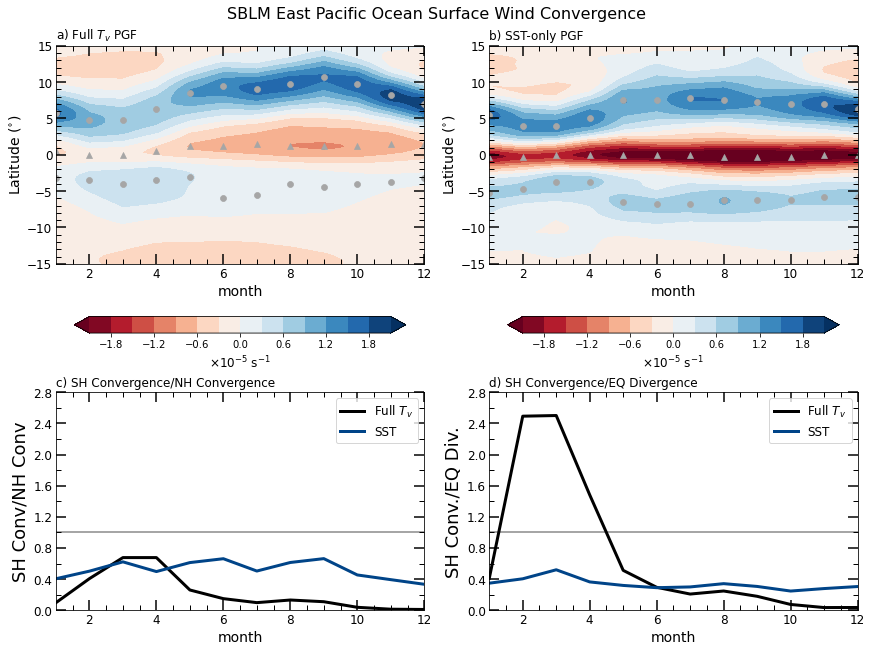

In [31]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

npan = 4
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(12, 15), constrained_layout='true')
fig.suptitle(r'SBLM East Pacific Ocean Surface Wind Convergence', fontsize=16)
for j in range(0,npan,1):
   ax1 = plt.subplot(4,2,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', labelsize=12)
   ax1.tick_params(axis='y', labelsize=12)
   #plt.gca().invert_yaxis() 
   plt.xlabel('month', fontsize=14)
   plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.ylim(-15,15)
   if j == 0:
       plt.title(r'a) Full $T_{v}$ PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_tv.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
       cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
       sc = plt.scatter(month,lat_NH_tv,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_SH_tv,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_EQ_tv,color='0.65', marker='^',linewidth=0.7)
   if j == 1:
       plt.title(r'b) SST-only PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_sst.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
       cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
       sc = plt.scatter(month,lat_NH_sst,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_SH_sst,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_EQ_sst,color='0.65', marker='^',linewidth=0.7)
   if j == 2: 
      plt.title(r'c) SH Convergence/NH Convergence',loc='left')
      color = 'k'
      lns1 = ax1.plot(month,cv_tv_SH/cv_tv_NH, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,cv_sst_SH/cv_sst_NH, color=color, linewidth='3')
      plt.legend([r'Full $T_{v}$','SST'],loc=1,fontsize=12)
      plt.ylabel('SH Conv/NH Conv', fontsize=18)
      plt.xlabel(r'month', fontsize=14) 
      plt.xlim(1,12)
      plt.ylim(0.,1.0)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
      plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)
      locs, labels = plt.yticks()  # Get the current locations and labels.
      plt.yticks(np.arange(0, 3.0, step=0.4))  # Set label locations.
      ax1.yaxis.set_minor_locator(MultipleLocator(0.2))
   if j == 3: 
      plt.title(r'd) SH Convergence/EQ Divergence',loc='left')
      color = 'k'
      lns1 = ax1.plot(month,-cv_tv_SH/cv_tv_EQ, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,-cv_sst_SH/cv_sst_EQ, color=color, linewidth='3')
      plt.legend([r'Full $T_{v}$','SST'],loc=1,fontsize=12)
      plt.ylabel('SH Conv./EQ Div.', fontsize=18)
      plt.xlabel(r'month', fontsize=14) 
      plt.xlim(1,12)
      plt.ylim(0.,1.0)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
      plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)
      locs, labels = plt.yticks()  # Get the current locations and labels.
      plt.yticks(np.arange(0, 3.0, step=0.4))  # Set label locations.
      ax1.yaxis.set_minor_locator(MultipleLocator(0.2))
   if j == 4:
      plt.title(r'e) $T_{v,850-900}$-only PGF',loc='left')
      cf = plt.contourf(month, lat_sblm, c_tv_FT.transpose()*10**5, cmap = color_map_rb, levels=lev_p_upper, extend = 'both')
      cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
      cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
   if j == 5:
      plt.title(r'f) PGF$_{850}$',loc='left')
      cf = plt.contourf(month, lat_sblm, c_gp.transpose()*10**5, cmap = color_map_rb, levels=lev_p_upper, extend = 'both')
      cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
      cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
# This plot tells us the magnitude of the divergence and convergence is way too strong in SST only simulations
# However, it doesn't say whether or not the latitudinal pattern is off

#plt.savefig(figfolder+'SBLM_Convergence_Tv_vs_SST.pdf', dpi=150)

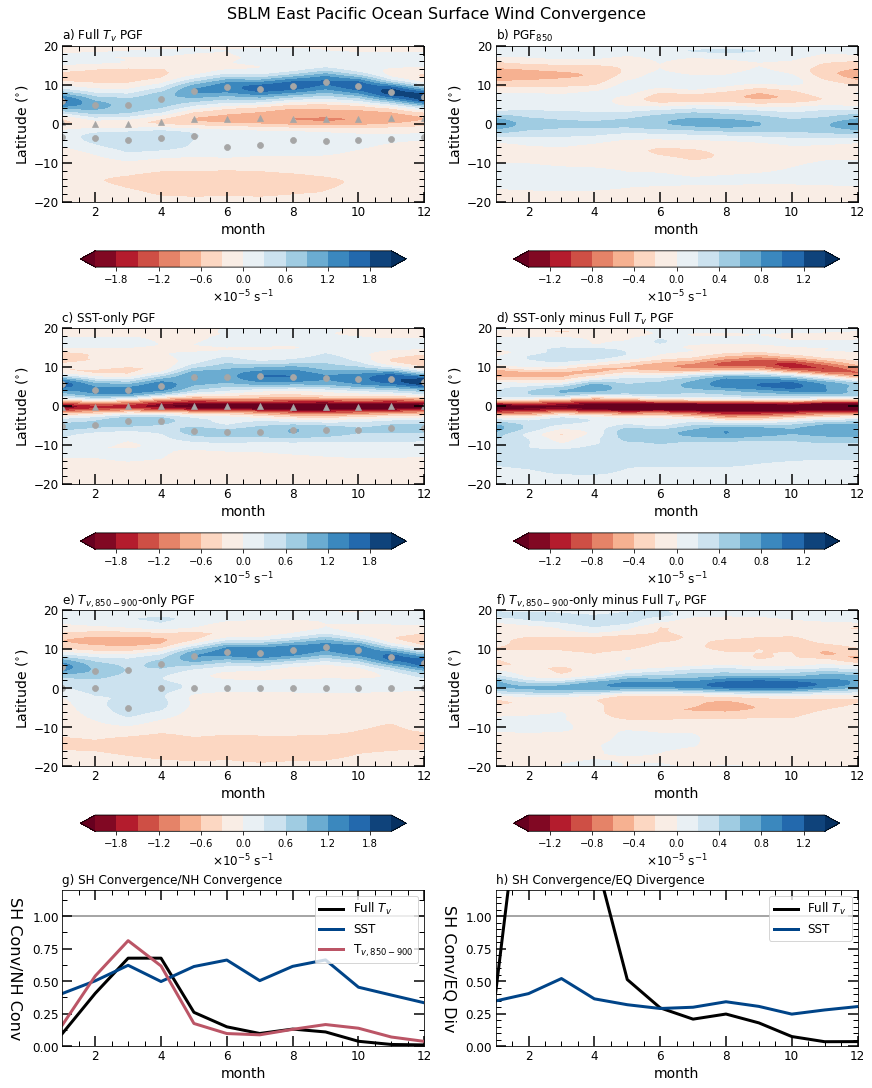

In [32]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

npan = 8
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(12, 15), constrained_layout='true')
fig.suptitle(r'SBLM East Pacific Ocean Surface Wind Convergence', fontsize=16)
for j in range(0,npan,1):
   ax1 = plt.subplot(4,2,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', labelsize=12)
   ax1.tick_params(axis='y', labelsize=12)
   #plt.gca().invert_yaxis() 
   plt.xlabel('month', fontsize=14)
   if j < 6:
       plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.ylim(-20,20)
   if j == 0:
       plt.title(r'a) Full $T_{v}$ PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_tv.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
       cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
       sc = plt.scatter(month,lat_NH_tv,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_SH_tv,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_EQ_tv,color='0.65', marker='^',linewidth=0.7)
   if j == 1:
      plt.title(r'b) PGF$_{850}$',loc='left')
      cf = plt.contourf(month, lat_sblm, c_gp.transpose()*10**5, cmap = color_map_rb, levels=lev_p*2/3, extend = 'both')
      cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
      cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
   if j == 2:
       plt.title(r'c) SST-only PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_sst.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       #cl = plt.contour(month, lat_sblm, (c_sst-c_tv)*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
       cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
       sc = plt.scatter(month,lat_NH_sst,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_SH_sst,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_EQ_sst,color='0.65', marker='^',linewidth=0.7)
   if j == 3:
       plt.title(r'd) SST-only minus Full $T_{v}$ PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, (c_sst-c_tv).transpose()*10**5, cmap = color_map_rb, levels=lev_p*2/3, extend = 'both')
       #cl = plt.contour(month, lat_sblm, (c_sst-c_tv)*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
       cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
       #sc = plt.scatter(month,lat_NH_sst,color='0.65',linewidth=0.7)
       #sc = plt.scatter(month,lat_SH_sst,color='0.65',linewidth=0.7)
       #sc = plt.scatter(month,lat_EQ_sst,color='0.65', marker='^',linewidth=0.7)
   if j == 4:
      plt.title(r'e) $T_{v,850-900}$-only PGF',loc='left')
      cf = plt.contourf(month, lat_sblm, c_tv_FT.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
      sc = plt.scatter(month,lat_NH_tv_FT,color='0.65',linewidth=0.7)
      sc = plt.scatter(month,lat_SH_tv_FT,color='0.65',linewidth=0.7)
      cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
      cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
   if j == 5:
      plt.title(r'f) $T_{v,850-900}$-only minus Full $T_{v}$ PGF',loc='left')
      cf = plt.contourf(month, lat_sblm, (c_tv_FT-c_tv).transpose()*10**5, cmap = color_map_rb, levels=lev_p*2/3, extend = 'both')
      #sc = plt.scatter(month,lat_NH_tv_FT,color='0.65',linewidth=0.7)
      #sc = plt.scatter(month,lat_SH_tv_FT,color='0.65',linewidth=0.7)
      cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
      cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
   if j == 6: 
      plt.title(r'g) SH Convergence/NH Convergence',loc='left')
      color = 'k'
      lns1 = ax1.plot(month,cv_tv_SH/cv_tv_NH, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,cv_sst_SH/cv_sst_NH, color=color, linewidth='3')
      color = '#BB5566'
      lns3 = ax1.plot(month,cv_tv_FT_SH/cv_tv_FT_NH, color=color, linewidth='3')
      plt.ylabel('SH Conv/NH Conv', fontsize=16, rotation=270, labelpad=25)
      plt.legend([r'Full $T_{v}$','SST',r'T$_{v,850-900}$'],loc=1,fontsize=12)
      plt.xlabel(r'month', fontsize=14) 
      plt.xlim(1,12)
      plt.ylim(0.,1.2)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
      plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)
      locs, labels = plt.yticks()  # Get the current locations and labels.
      plt.yticks(np.arange(0, 1.1, step=0.25))  # Set label locations.
      ax1.yaxis.set_minor_locator(MultipleLocator(0.125))
   if j == 7: 
      plt.title(r'h) SH Convergence/EQ Divergence',loc='left')
      color = 'k'
      lns1 = ax1.plot(month,-cv_tv_SH/cv_tv_EQ, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,-cv_sst_SH/cv_sst_EQ, color=color, linewidth='3')
      #plt.legend([r'Full $T_{v}$','SST'],loc=9,fontsize=12)
      #color = '#BB5566'
      #lns3 = ax1.plot(month,cv_tv_FT_SH/cv_tv_FT_NH*100, color=color, linewidth='3')
      plt.legend([r'Full $T_{v}$','SST',r'T$_{v,850-900}$'],loc=1,fontsize=12)
      plt.ylabel('SH Conv/EQ Div', fontsize=16, rotation=270, labelpad=25)
      plt.xlabel(r'month', fontsize=14) 
      plt.xlim(1,12)
      plt.ylim(0.,1.2)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
      plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)
      locs, labels = plt.yticks()  # Get the current locations and labels.
      plt.yticks(np.arange(0, 1.1, step=0.25))  # Set label locations.
      #ax1.yaxis.set_minor_locator(MultipleLocator(0.125))   
      #ax1.yaxis.set_label_position("right")
      #ax1.yaxis.tick_right()
# This plot tells us the magnitude of the divergence and convergence is way too strong in SST only simulations
# However, it doesn't say whether or not the latitudinal pattern is off

#plt.savefig(figfolder+'SBLM_Convergence_with_anom.pdf', dpi=150)

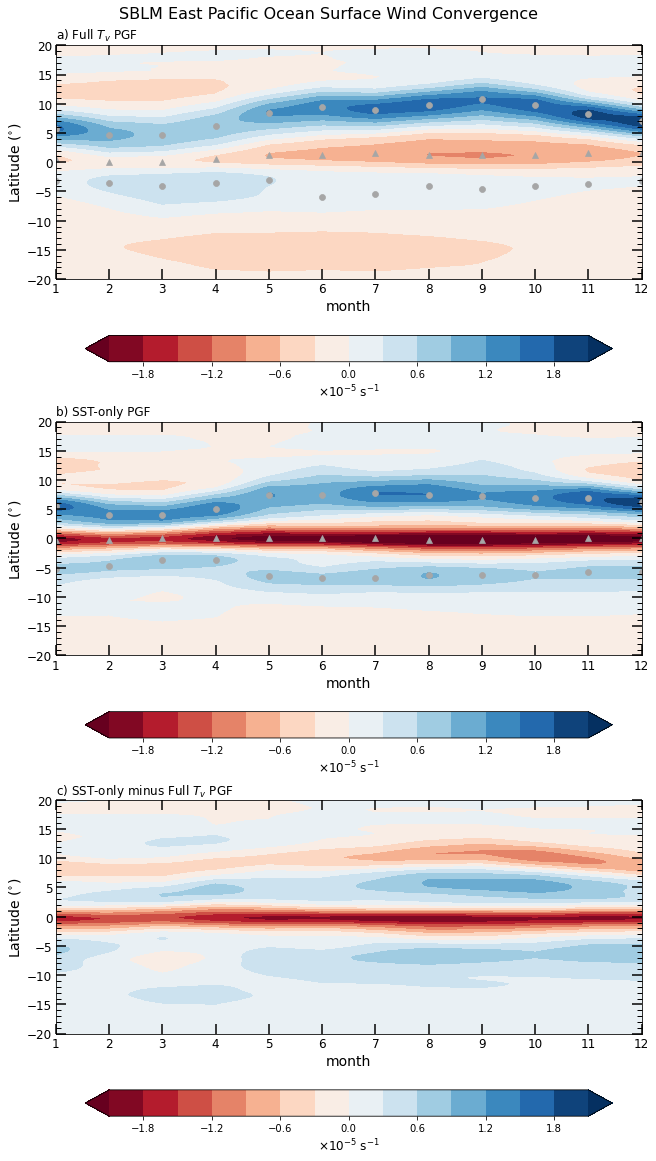

In [33]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

npan = 3
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(9, 16), constrained_layout='true')
fig.suptitle(r'SBLM East Pacific Ocean Surface Wind Convergence', fontsize=16)
for j in range(0,npan,1):
   ax1 = plt.subplot(npan,1,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='y', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', which='minor', length= 0, width=1.0, direction='in', labelsize=12, right='True', top='True')
   #plt.gca().invert_yaxis() 
   plt.xlabel('month', fontsize=14)
   if j < 6:
       plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.ylim(-20,20)
   if j == 0:
       plt.title(r'a) Full $T_{v}$ PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_tv.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
       cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
       sc = plt.scatter(month,lat_NH_tv,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_SH_tv,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_EQ_tv,color='0.65', marker='^',linewidth=0.7)
   if j == 1:
       plt.title(r'b) SST-only PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_sst.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       #cl = plt.contour(month, lat_sblm, (c_sst-c_tv)*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
       cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
       sc = plt.scatter(month,lat_NH_sst,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_SH_sst,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_EQ_sst,color='0.65', marker='^',linewidth=0.7)
   if j == 2:
       plt.title(r'c) SST-only minus Full $T_{v}$ PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, (c_sst-c_tv).transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       #cl = plt.contour(month, lat_sblm, (c_sst-c_tv)*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
       cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
       #sc = plt.scatter(month,lat_NH_sst,color='0.65',linewidth=0.7)
       #sc = plt.scatter(month,lat_SH_sst,color='0.65',linewidth=0.7)
       #sc = plt.scatter(month,lat_EQ_sst,color='0.65', marker='^',linewidth=0.7)
   plt.xticks(np.arange(1,13, step=1))  # Set label locations.
# This plot tells us the magnitude of the divergence and convergence is way too strong in SST only simulations
# However, it doesn't say whether or not the latitudinal pattern is off

plt.savefig(figfolder+'SBLM_Convergence_with_anom_final_new.pdf', dpi=150)

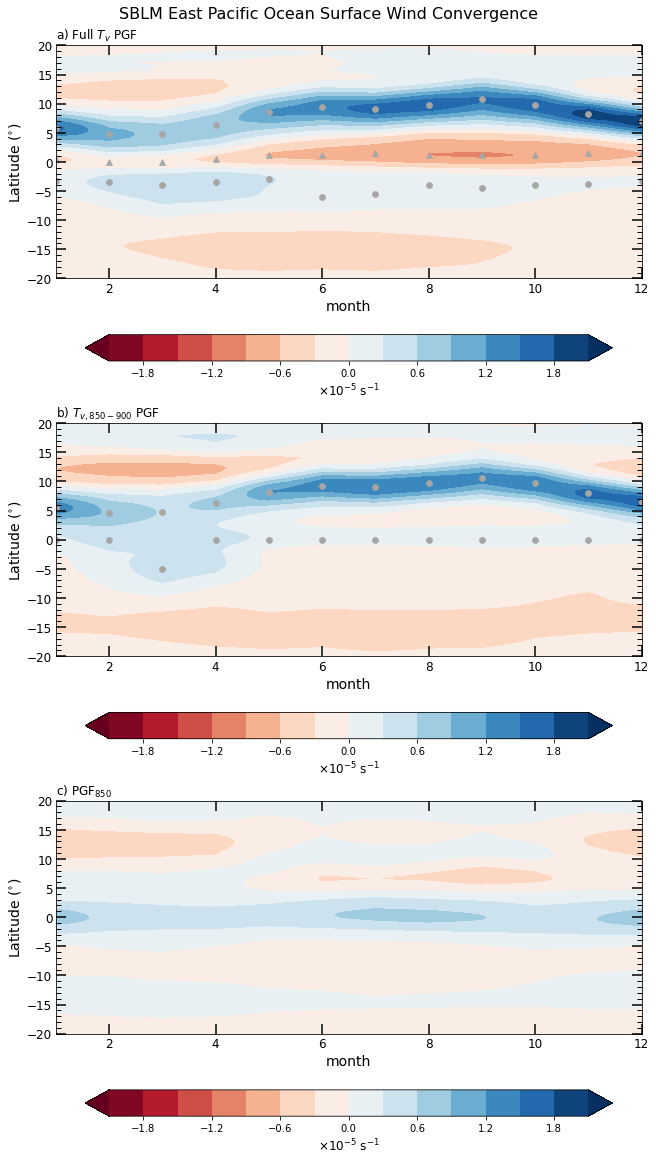

In [34]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

npan = 3
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(9, 16), constrained_layout='true')
fig.suptitle(r'SBLM East Pacific Ocean Surface Wind Convergence', fontsize=16)
for j in range(0,npan,1):
   ax1 = plt.subplot(npan,1,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='y', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', which='minor', length= 0, width=1.0, direction='in', labelsize=12, right='True', top='True')
   #plt.gca().invert_yaxis() 
   plt.xlabel('month', fontsize=14)
   if j < 6:
       plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.ylim(-20,20)
   if j == 0:
       plt.title(r'a) Full $T_{v}$ PGF',loc='left')
       cf = plt.contourf(month, lat_sblm, c_tv.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
       cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
       sc = plt.scatter(month,lat_NH_tv,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_SH_tv,color='0.65',linewidth=0.7)
       sc = plt.scatter(month,lat_EQ_tv,color='0.65', marker='^',linewidth=0.7)
   if j == 1:
      plt.title(r'b) $T_{v,850-900}$ PGF',loc='left')
      cf = plt.contourf(month, lat_sblm, c_tv_FT.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
      sc = plt.scatter(month,lat_NH_tv_FT,color='0.65',linewidth=0.7)
      sc = plt.scatter(month,lat_SH_tv_FT,color='0.65',linewidth=0.7)
      cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
      cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
   if j == 2:
       plt.title(r'c) PGF$_{850}$',loc='left')
       cf = plt.contourf(month, lat_sblm, c_gp.transpose()*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'horizontal',shrink=0.9, pad=0.08)
       cb.set_label(r'$\times 10^{-5}$ s$^{-1}$', fontsize=12)
# This plot tells us the magnitude of the divergence and convergence is way too strong in SST only simulations
# However, it doesn't say whether or not the latitudinal pattern is off

plt.savefig(figfolder+'SBLM_Convergence_suppl_new.pdf', dpi=150)

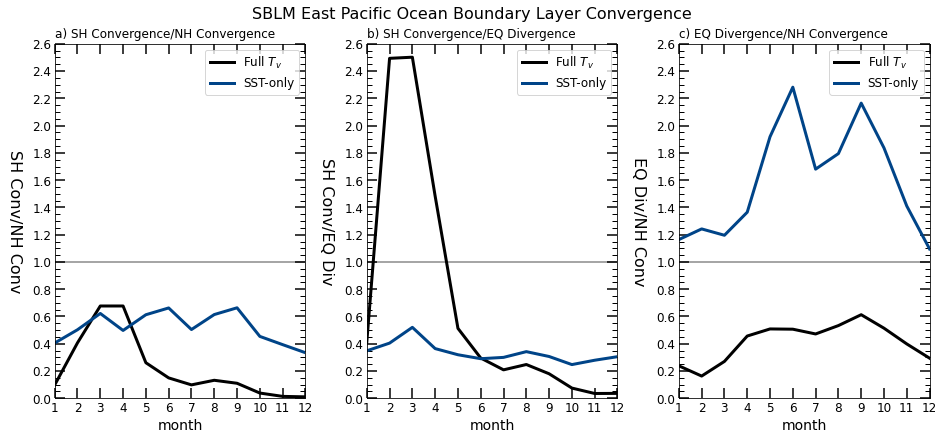

In [83]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

npan = 3
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(13, 6), constrained_layout='true')
fig.suptitle(r'SBLM East Pacific Ocean Surface Wind Convergence', fontsize=16)
for j in range(0,npan,1):
   ax1 = plt.subplot(1,npan,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='y', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', which='minor', length= 0, width=1.0, direction='in', labelsize=12, right='True', top='True')
   #ax1.tick_params(axis='x', labelsize=12)
   #ax1.tick_params(axis='y', labelsize=12)
   #plt.gca().invert_yaxis() 
   plt.xlabel('month', fontsize=14)
   if j < 6:
       plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.ylim(-15,15)
   if j == 0: 
      plt.title(r'a) SH Convergence/NH Convergence',loc='left')
      color = 'k'
      lns1 = ax1.plot(month,cv_tv_SH/cv_tv_NH, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,cv_sst_SH/cv_sst_NH, color=color, linewidth='3')
      color = '#BB5566'
      #lns3 = ax1.plot(month,cv_tv_FT_SH/cv_tv_FT_NH, color=color, linewidth='3')
      plt.ylabel('SH Conv/NH Conv', fontsize=16, rotation=270, labelpad=25)
      plt.legend([r'Full $T_{v}$','SST-only',r'T$_{v,850-900}$'],loc=1,fontsize=12)
      plt.xlabel(r'month', fontsize=14) 
      plt.xlim(1,12)
      plt.ylim(0.,0.8)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
      plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)
      locs, labels = plt.yticks()  # Get the current locations and labels.
      plt.yticks(np.arange(0, 2.5, step=0.25))  # Set label locations.
      #ax1.yaxis.set_minor_locator(MultipleLocator(0.125))
   if j == 1: 
      plt.title(r'b) SH Convergence/EQ Divergence',loc='left')
      color = 'k'
      lns1 = ax1.plot(month,-cv_tv_SH/cv_tv_EQ, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,-cv_sst_SH/cv_sst_EQ, color=color, linewidth='3')
      #plt.legend([r'Full $T_{v}$','SST'],loc=9,fontsize=12)
      #color = '#BB5566'
      #lns3 = ax1.plot(month,cv_tv_FT_SH/cv_tv_FT_NH*100, color=color, linewidth='3')
      plt.legend([r'Full $T_{v}$','SST-only',r'T$_{v,850-900}$'],loc=1,fontsize=12)
      plt.ylabel('SH Conv/EQ Div', fontsize=16, rotation=270, labelpad=25)
      plt.xlabel(r'month', fontsize=14) 
      plt.xlim(1,12)
      plt.ylim(0.,0.8)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
      plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)
      #ax1.yaxis.set_minor_locator(MultipleLocator(0.125))   
      #ax1.yaxis.set_label_position("right")
      #ax1.yaxis.tick_right()
   if j == 2: 
      plt.title(r'c) EQ Divergence/NH Convergence',loc='left')
      color = 'k'
      lns1 = ax1.plot(month,-cv_tv_EQ/cv_tv_NH, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,-cv_sst_EQ/cv_sst_NH, color=color, linewidth='3')
      #plt.legend([r'Full $T_{v}$','SST'],loc=9,fontsize=12)
      #color = '#BB5566'
      #lns3 = ax1.plot(month,cv_tv_FT_SH/cv_tv_FT_NH*100, color=color, linewidth='3')
      plt.legend([r'Full $T_{v}$','SST-only',r'T$_{v,850-900}$'],loc=1,fontsize=12)
      plt.ylabel('EQ Div/NH Conv', fontsize=16, rotation=270, labelpad=25)
      plt.xlabel(r'month', fontsize=14) 
      plt.xlim(1,12)
      plt.ylim(0.,2.5)
      plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-1)
      plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)
      #ax1.yaxis.set_minor_locator(MultipleLocator(0.125))   
      #ax1.yaxis.set_label_position("right")
      #ax1.yaxis.tick_right()
   
   plt.yticks(np.arange(0, 2.7, step=0.2))  # Set label locations.
   plt.xticks(np.arange(1,13, step=1))  # Set label locations.
   #plt.setp(plt.get_xticklabels()[::2], visible=False)
# This plot tells us the magnitude of the divergence and convergence is way too strong in SST only simulations
# However, it doesn't say whether or not the latitudinal pattern is off

plt.savefig(figfolder+'SBLM_Convergence_ratios_allthree.pdf', dpi=150)

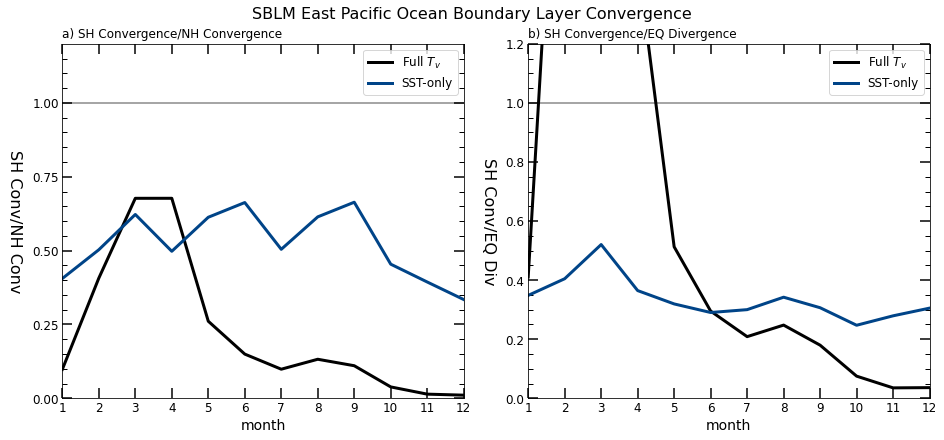

In [94]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

npan = 2
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(13, 6), constrained_layout='true')
fig.suptitle(r'SBLM East Pacific Ocean Surface Wind Convergence', fontsize=16)
for j in range(0,npan,1):
   ax1 = plt.subplot(1,npan,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='y', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', which='minor', length= 0, width=1.0, direction='in', labelsize=12, right='True', top='True')
   #ax1.tick_params(axis='x', labelsize=12)
   #ax1.tick_params(axis='y', labelsize=12)
   #plt.gca().invert_yaxis() 
   plt.xlabel('month', fontsize=14)
   if j < 6:
       plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   #plt.ylim(-15,15)
   if j == 0: 
      plt.title(r'a) SH Convergence/NH Convergence',loc='left')
      color = 'k'
      lns1 = ax1.plot(month,cv_tv_SH/cv_tv_NH, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,cv_sst_SH/cv_sst_NH, color=color, linewidth='3')
      color = '#BB5566'
      #lns3 = ax1.plot(month,cv_tv_FT_SH/cv_tv_FT_NH, color=color, linewidth='3')
      plt.ylabel('SH Conv/NH Conv', fontsize=16, rotation=270, labelpad=25)
      plt.legend([r'Full $T_{v}$','SST-only',r'T$_{v,850-900}$'],loc=1,fontsize=12)
      plt.xlabel(r'month', fontsize=14) 
      #plt.xlim(1,12)
      #plt.ylim(0.,1.2)
      plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)
      locs, labels = plt.yticks()  # Get the current locations and labels.
      plt.yticks(np.arange(0, 2.5, step=0.25))  # Set label locations.
      #ax1.yaxis.set_minor_locator(MultipleLocator(0.125))
   if j == 1: 
      plt.title(r'b) SH Convergence/EQ Divergence',loc='left')
      color = 'k'
      lns1 = ax1.plot(month,-cv_tv_SH/cv_tv_EQ, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,-cv_sst_SH/cv_sst_EQ, color=color, linewidth='3')
      #plt.legend([r'Full $T_{v}$','SST'],loc=9,fontsize=12)
      #color = '#BB5566'
      #lns3 = ax1.plot(month,cv_tv_FT_SH/cv_tv_FT_NH*100, color=color, linewidth='3')
      plt.legend([r'Full $T_{v}$','SST-only',r'T$_{v,850-900}$'],loc=1,fontsize=12)
      plt.ylabel('SH Conv/EQ Div', fontsize=16, rotation=270, labelpad=25)
      plt.xlabel(r'month', fontsize=14) 
      #plt.xlim(1,12)
      #plt.ylim(0.,1.2)
      plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)
      #ax1.yaxis.set_minor_locator(MultipleLocator(0.125))   
      #ax1.yaxis.set_label_position("right")
      #ax1.yaxis.tick_right()
   if j == 2: 
      plt.title(r'c) EQ Divergence/NH Convergence',loc='left')
      color = 'k'
      lns1 = ax1.plot(month,-cv_tv_EQ/cv_tv_NH, color=color, linewidth='3')
      color = '#004488'
      lns2 = ax1.plot(month,-cv_sst_EQ/cv_sst_NH, color=color, linewidth='3')
      #plt.legend([r'Full $T_{v}$','SST'],loc=9,fontsize=12)
      #color = '#BB5566'
      #lns3 = ax1.plot(month,cv_tv_FT_SH/cv_tv_FT_NH*100, color=color, linewidth='3')
      plt.legend([r'Full $T_{v}$','SST-only',r'T$_{v,850-900}$'],loc=1,fontsize=12)
      plt.ylabel('EQ Div/NH Conv', fontsize=16, rotation=270, labelpad=25)
      plt.xlabel(r'month', fontsize=14) 
      #plt.ylim(0.,1.2)
      plt.axhline(1, color='0.65', linewidth = 2.0, zorder=-1)
      #ax1.yaxis.set_minor_locator(MultipleLocator(0.125))   
      #ax1.yaxis.set_label_position("right")
      #ax1.yaxis.tick_right()
   
   plt.ylim(0,1.2)
   plt.xlim(1,12)
   #plt.yticks(np.arange(0, 1.1, step=0.2))  # Set label locations.
   plt.xticks(np.arange(1,13, step=1))  # Set label locations.
   #plt.setp(plt.get_xticklabels()[::2], visible=False)
# This plot tells us the magnitude of the divergence and convergence is way too strong in SST only simulations
# However, it doesn't say whether or not the latitudinal pattern is off

plt.savefig(figfolder+'SBLM_Convergence_ratios_final_new.pdf', dpi=150)

In [70]:
-cv_tv_EQ/cv_tv_NH

<xarray.DataArray 'w' (month: 12)>
array([0.23823119, 0.16313971, 0.27060417, 0.45671581, 0.50871347,
       0.50685595, 0.47184982, 0.53334906, 0.61310661, 0.51419382,
       0.39871581, 0.29424035])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [71]:
-cv_sst_EQ/cv_sst_NH

<xarray.DataArray 'w' (month: 12)>
array([1.16412839, 1.24229413, 1.19572865, 1.36488053, 1.91836729,
       2.28172173, 1.68063611, 1.79468397, 2.16496492, 1.8362842 ,
       1.41007307, 1.09520342])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
npan = 3
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(15, 12), tight_layout='true')
#fig.suptitle('Slab boundary layer model vs. ERA5 climatology for control run', fontsize=20)
for j in range(0,npan,1):
   ax1 = fig.add_subplot(2,2,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', labelsize=12)
   ax1.tick_params(axis='y', labelsize=12)
   #plt.gca().invert_yaxis() 
   plt.xlabel('month', fontsize=14)
   plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.ylim(-15,15)
   if j == 0:
       plt.title('Full T_v PGF anom')
       cf = plt.contourf(month, lat_sblm, (c_tv - c_FT)*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 1:
       plt.title('SST PGF anom')
       cf = plt.contourf(month, lat_sblm, (c_sst - c_FT)*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 2:
       plt.title('Tv 850 hPa PGF anom')
       cf = plt.contourf(month, lat_sblm, (c_tv_FT - c_FT)*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 3:
       plt.title('850 hPa PGF')
       cf = plt.contourf(month, lat_sblm, (c_FT)*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 4:
       plt.title('SST PGF anom')
       cf = plt.contourf(month, lat_sblm, (c_sst - c_tv)*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')

In [ ]:
npan = 3
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(15, 12), tight_layout='true')
#fig.suptitle('Slab boundary layer model vs. ERA5 climatology for control run', fontsize=20)
for j in range(0,npan,1):
   ax1 = fig.add_subplot(2,2,j+1)
   plt.minorticks_on()
   ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=12, right='True', top='True')
   ax1.tick_params(axis='x', labelsize=12)
   ax1.tick_params(axis='y', labelsize=12)
   #plt.gca().invert_yaxis() 
   plt.xlabel('month', fontsize=14)
   plt.ylabel('Latitude ($^{\circ}$)', fontsize=14)
   #plt.axhline(850, color='0.65', linewidth = 2.0)
   plt.ylim(-15,15)
   if j == 0:
       plt.title('Full T_v PGF')
       cf = plt.contourf(month, lat_sblm, c_tv*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 1:
       plt.title('SST PGF')
       cf = plt.contourf(month, lat_sblm, c_sst*10**5, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')
   if j == 2:
       plt.title('SST PGF anom')
       cf = plt.contourf(month, lat_sblm, (c_sst - c_tv)*10**5/2, cmap = color_map_rb, levels=lev_p, extend = 'both')
       cb = plt.colorbar(cf,orientation = 'vertical')